# My Model
#### This model will use NMF on the cell line x drug df to create latent vectors of each that will be used as features in a tensorflow predictor

In [26]:
import pandas as pd
import numpy as np
import optuna
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Import SimpleImputer for imputation



## Read DF and create latent vectors

In [27]:
# Function to calculate NDCG
def ndcg_at_k(y_true, y_pred, k=10):
    """
    Compute the Normalized Discounted Cumulative Gain (NDCG) at rank k.
    
    Parameters:
    - y_true: True IC50 values (array-like)
    - y_pred: Predicted IC50 values (array-like)
    - k: Rank position for NDCG (default 10)
    
    Returns:
    - NDCG score (float)
    """
    # Sort the true values and predicted values in descending order
    order_true = np.argsort(y_true)[::-1]
    order_pred = np.argsort(y_pred)[::-1]
    
    # Compute DCG
    dcg = 0
    for i in range(k):
        if i < len(y_true):
            # Discounted Cumulative Gain (DCG)
            dcg += (2**y_true[order_pred[i]] - 1) / np.log2(i + 2)
    
    # Compute Ideal DCG (IDCG)
    idcg = 0
    for i in range(k):
        if i < len(order_true):
            idcg += (2**y_true[order_true[i]] - 1) / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0

### Make Latent Vectors

In [28]:
df_path='../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv'
df = pd.read_csv(df_path)
cell_line_obs_df = pd.read_csv(df_path, index_col=0)
    
# Impute missing values using the mean of each column (drug)
imputer = SimpleImputer(strategy='mean')  # You can also try median or other strategies
cell_line_obs_df_imputed = imputer.fit_transform(cell_line_obs_df)
# Apply Truncated SVD for matrix factorization
svd = TruncatedSVD(n_components=6)
latent_matrix = svd.fit_transform(cell_line_obs_df_imputed)

num_cell_lines = latent_matrix.shape[0]  # Rows of the latent matrix (cell lines)
num_drugs = cell_line_obs_df.shape[1]    # Columns of the original matrix (drugs)

num_cell_lines, num_drugs

features = []
targets = []

# Loop over each cell line and drug combination
for i in range(num_cell_lines):
    for j in range(num_drugs):
        # Get the latent vector for the cell line i
        cell_line_latent = latent_matrix[i]    
        # Get the latent vector for the drug j
        drug_latent = svd.components_[:, j] 
        feature_vector = np.concatenate([cell_line_latent, drug_latent])
        ic50_value = cell_line_obs_df_imputed[i, j]
        features.append(feature_vector)
        targets.append(ic50_value)

# Convert the feature list and target list to numpy arrays
features = np.array(features)
targets = np.array(targets)

### Train / Test model

In [ ]:
hidden_units = 160
learning_rate = 0.0009647420370192299
frac_test = 0.2

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=frac_test, random_state=0)

# Build the neural network model in TensorFlow
model = keras.Sequential([ 
    layers.InputLayer(input_shape=(X_train.shape[1],)), 
    layers.Dense(hidden_units, activation='relu'), 
    layers.Dense(1)  # Single output unit for predicting IC50 value 
])

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mse',  # Mean squared error for regression
              metrics=['mae'])  # Mean absolute error for evaluation

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model on the validation set (R^2 score)
y_pred = model.predict(X_test).flatten()  # Flatten to match dimensions

1518/1518 [==============================] - 1s 784us/step
R^2 Score: 0.7505, NDCG at 10: 0.6116


### Evaluate

In [ ]:
# Calculate R^2
r2_score = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

# Calculate NDCG at rank 10
ndcg_score = ndcg_at_k(y_test, y_pred, k=10)

print(f"R^2 Score: {r2_score:.4f}, NDCG at 10: {ndcg_score:.4f}")

### Latent Feature Similarity vs Fingerprint Similarity

In [81]:
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import requests
import time

cid_to_smiles_cache = {}

def get_smiles_from_cid(cid):
    """Retrieve the SMILES string for a given PubChem Compound ID (CID)."""
    if cid in cid_to_smiles_cache:
        return cid_to_smiles_cache[cid]
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/JSON"
    response = requests.get(url)
    time.sleep(0.1)
    if response.status_code == 200:
        data = response.json()
        properties = data.get("PropertyTable", {}).get("Properties", [])
        if properties:
            smiles = properties[0].get("CanonicalSMILES")
            cid_to_smiles_cache[cid] = smiles
            return smiles
    raise ValueError(f"SMILES not found for CID {cid}.")

def compute_fp_similarity_from_cid(cid1, cid2):
    """Compute fingerprint similarity between two compounds using PubChem CIDs."""
    if not str(cid1).isdigit() or not str(cid2).isdigit():
        return 0
    try:
        # Get SMILES strings for the CIDs
        smiles1 = get_smiles_from_cid(cid1)
        smiles2 = get_smiles_from_cid(cid2)
    
        # Convert SMILES to RDKit Molecules
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
    
        if not mol1 or not mol2:
            raise ValueError("Could not parse SMILES into valid molecules.")
    
        # Compute fingerprints
        fp1 = FingerprintMols.FingerprintMol(mol1)
        fp2 = FingerprintMols.FingerprintMol(mol2)
    
        # Compute similarity
        similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
        return similarity
    except Exception as e:
        print(f"Error computing similarity for CIDs {cid1} and {cid2}: {e}")
        return 0


##### Fingerprint Similarity Counts

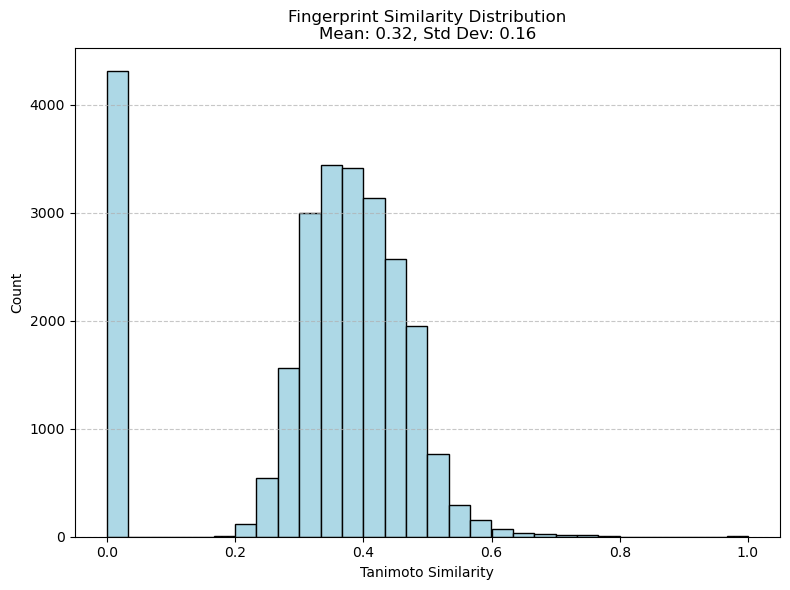

Average Tanimoto similarity: 0.3238567400130435
Standard deviation of Tanimoto similarity: 0.16182750742100038


In [82]:
import matplotlib.pyplot as plt
from itertools import combinations

dataset_drug_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0) # hn_drug_stat | drug_stat
dataset_drug_df.index = dataset_drug_df.index.astype(str)
pubchem_cids = dataset_drug_df.iloc[:, 6].to_dict()

assert(len(pubchem_cids) == svd.components_.shape[1])

fp_similarities = []

compound_pairs = list(combinations(pubchem_cids.values(), 2)) 

for compound1, compound2 in compound_pairs:
    similarity = compute_fp_similarity_from_cid(compound1, compound2)
    fp_similarities.append(similarity)

mean_similarity = np.mean(fp_similarities)
std_dev_similarity = np.std(fp_similarities)

plt.figure(figsize=(8, 6))
plt.hist(fp_similarities, bins=30, color='lightblue', edgecolor='black')
plt.title(f"Fingerprint Similarity Distribution\nMean: {mean_similarity:.2f}, Std Dev: {std_dev_similarity:.2f}")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Average Tanimoto similarity:", mean_similarity)
print("Standard deviation of Tanimoto similarity:", std_dev_similarity)

##### Latent Vector Counts

In [110]:
def compute_cos_sim(vec1, vec2, normalize=True):
    """Compute cosine similarity between two vectors, optionally normalized to [0, 1]."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Avoid division by zero, return 0 if either vector is zero-length
    
    cosine_sim = dot_product / (norm1 * norm2)
    
    if normalize:
        # Normalize to [0, 1] range
        return (cosine_sim + 1) / 2
    return cosine_sim

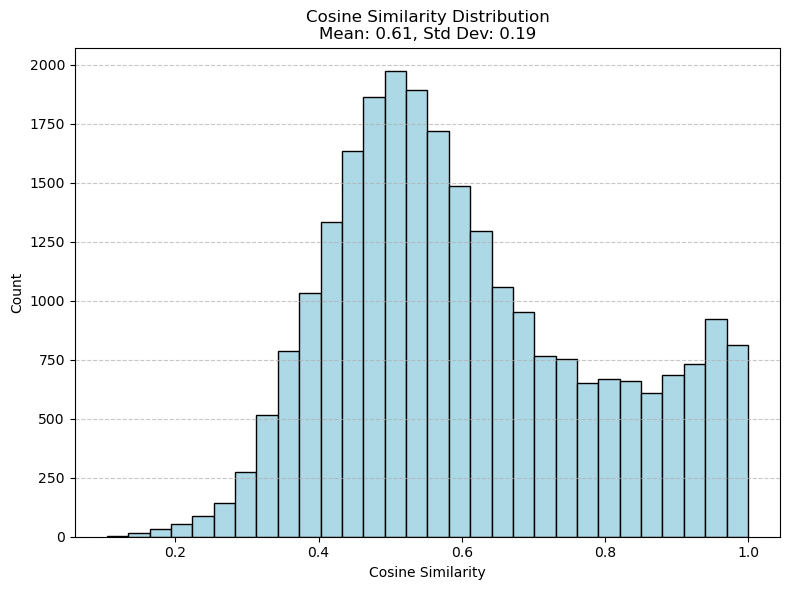

Average Cosine similarity: 0.6073322741261765
Standard deviation of Cosine similarity: 0.18547922360768654


In [111]:
lv_similarities = []
lv_pairs = list()

for i in range(svd.components_.shape[1]):
        for j in range(i + 1, (svd.components_.shape[1])):
                lv_pairs.append((svd.components_[:,i], svd.components_[:,j]))

for lv1, lv2 in lv_pairs:
        lv_sim = compute_cos_sim(lv1, lv2)
        lv_similarities.append(lv_sim)

lv_mean_similarity = np.mean(lv_similarities)
lv_std_dev_similarity = np.std(lv_similarities)

plt.figure(figsize=(8, 6))
plt.hist(lv_similarities, bins=30, color='lightblue', edgecolor='black')
plt.title(f"Cosine Similarity Distribution\nMean: {lv_mean_similarity:.2f}, Std Dev: {lv_std_dev_similarity:.2f}")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Average Cosine similarity:", lv_mean_similarity)
print("Standard deviation of Cosine similarity:", lv_std_dev_similarity)

#### Fingerprint Similarity vs Latent Vector Similarity


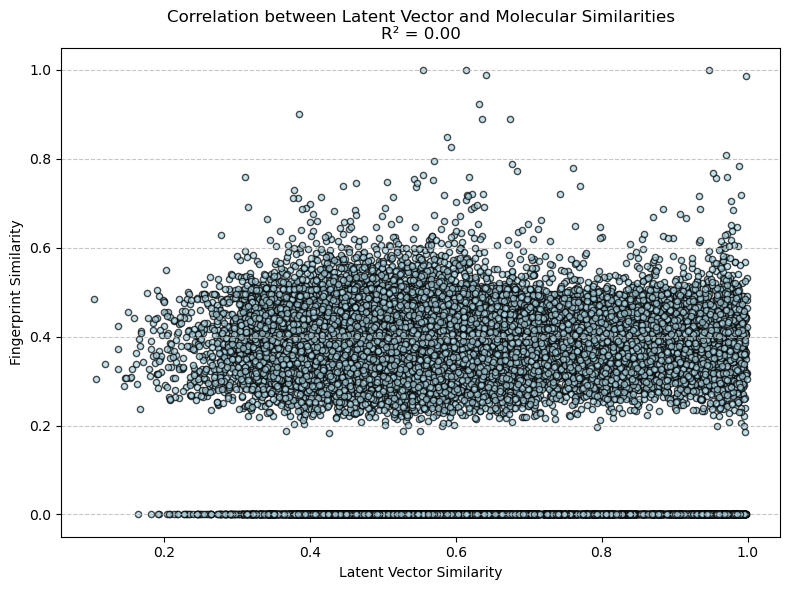

In [112]:
from scipy.stats import pearsonr

r_value, _ = pearsonr(lv_similarities, fp_similarities)
r_squared = r_value**2

plt.figure(figsize=(8, 6))
plt.scatter(lv_similarities, fp_similarities, alpha=0.7, s=20, color='lightblue', edgecolor='black')
plt.title(f"Correlation between Latent Vector and Molecular Similarities\nR² = {r_squared:.2f}")
plt.xlabel("Latent Vector Similarity")
plt.ylabel("Fingerprint Similarity")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()